# Parallel vs Series PV Configurations

This post evaluates, using pvlib and pvmismatch, the resiliance of parallel and series PV configurations to produce power under different exposures and with mixed panel types.  This evaluation is applicable to small mobile (RV and Marine) arrays.  The GitHub repository for the notebook that generated this post can be found [here](https://github.com/natecostello/pv-series-parallel).

#### TLDR: Parallel is the optimal panel configuration for RV and Marine applications subject to differing irradiance among panels.  Unless cabling or battery voltage requires series configurations, use parallel.

## Setup and Helper Functions

In [41]:
import pvmismatch
from pvmismatch.contrib.gen_coeffs import gen_two_diode

from pvlib import pvsystem, location, solarposition
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import solarpanels
from pprint import pprint as pp

panel_temp = 323.15 # 50C

A helper function to determine the solar characteristics for Key West in January, assuming clear skies, and a a provided surface tilt.

In [42]:
def getSun(surface_tilt, shaded):
    sigsbee = location.Location(24.5833, -81.767, 'US/Eastern', 0, 'Sigsbee Park')
    times = pd.date_range(start='2024-01-20', 
                          end='2024-01-21', 
                          freq='1min', 
                          tz=sigsbee.tz)
    cs = sigsbee.get_clearsky(times)
    solpos = sigsbee.get_solarposition(times)
    pvSys = pvsystem.PVSystem(surface_tilt=surface_tilt)
    irradiance = pvSys.get_irradiance(solpos['zenith'], 
                                      solpos['azimuth'], 
                                      cs['ghi'], 
                                      cs['dni'], 
                                      cs['dhi'])
    if shaded:
        return irradiance['poa_diffuse'].max()/1000.0
    else:
        return irradiance['poa_global'].max()/1000.0

A helper function to plot systems.

In [43]:
def plot_system(pvs, title=None):
    fmt=''
    ax = plt.subplot(2, 1, 1)
    plt.plot(pvs.Vsys, pvs.Isys, fmt)
    plt.plot(pvs.Vmp, pvs.Imp, 'ro')
    plt.text(pvs.Vmp * (1 + 0.01), 
             pvs.Imp * (1 + 0.01), 
             'Pmp=' + str(round(pvs.Vmp*pvs.Imp,2)), 
             fontsize=10)
    plt.text(pvs.Vmp * (1 + 0.01),
             0.01*pvs.Imp + 0.05*pvs.Imp*(len(ax.lines)-1),
             'Vmp=' + str(round(pvs.Vmp,2)), 
             fontsize=10)
    plt.text(0.01 * pvs.Vmp,pvs.Imp * (0.9),
             'Imp=' + str(round(pvs.Imp,2)), 
             fontsize=10)
    plt.xlim(0, pvs.Voc * 1.1)
    plt.ylim(0, pvs.Isc * 1.1)
    plt.axvline(pvs.Vmp, color='r', linestyle=':')
    plt.axhline(pvs.Imp, color='r', linestyle=':')
    plt.title('System I-V Characteristics')
    plt.ylabel('System Current, I [A]')
    plt.grid()
    plt.subplot(2, 1, 2, sharex=ax)
    plt.plot(pvs.Vsys, pvs.Psys / 1000, fmt)
    plt.xlim(0, pvs.Voc * 1.1)
    plt.ylim(0, pvs.Pmp * 1.1 / 1000)
    plt.axvline(pvs.Vmp, color='r', linestyle=':')
    plt.axhline(pvs.Pmp / 1000, color='r', linestyle=':')
    plt.title('System P-V Characteristics')
    plt.xlabel('System Voltage, V [V]')
    plt.ylabel('System Power, P [kW]')
    plt.grid()
    if title is not None:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    

## PV Modules
This evaluation uses Rich Solar 12V 200W Panels.  From inspection, they have two internal substrings in series, with 18 cells in each substring, and two bypass diodes.


In [44]:
# get module parameters
module_params = solarpanels.get_rich_solar_MEGA200_12V()

# create a representative pvCell
pvc = pvmismatch.pvcell.PVcell(Isat1_T0=module_params['Isat1_T0'],
                               Isat2_T0=module_params['Isat2_T0'],
                               Rs=module_params['Rs_2d'],
                               Rsh=module_params['Rsh_2d'],
                               Isc0_T0=module_params['I_sc_ref'],
                               alpha_Isc=module_params['alpha_sc_percent'])

# create a representative pvModule
pvm = pvmismatch.pvmodule.PVmodule(cell_pos=module_params['cell_layout'], 
                                   Vbypass=[-0.5, -0.5],
                                      pvcells=[pvc]*module_params['N_s'])


Panel IV Curve at STC.  Note, the parameters do not match the datasheet values perfectly, but they are close enough for this comparative evaluation.

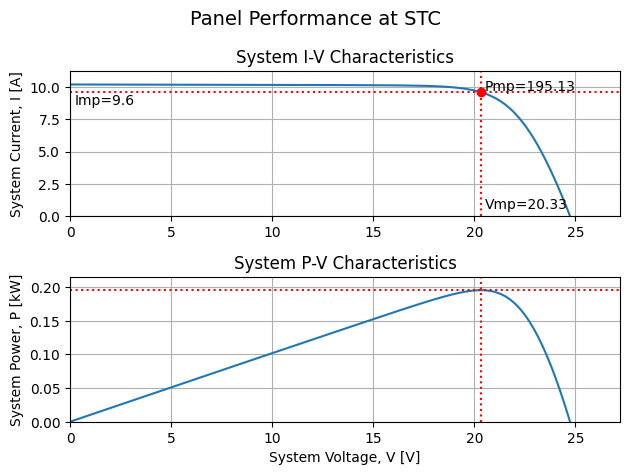

In [45]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm])
plot_system(pvs, title='Panel Performance at STC')

## Case studies

All case studies are performed with predicted irradiance for Key West, FL on January 21, 2024.  Unless stated otherwise, panel temperature is assumed to be 50C (122F) 

- Case 0 models a basic flat roof mount with a system of two flat mounted panels (in series and parallel).  This case will be the baseline power production used for cases 1, 2, and 3. 

- Case 1 models a curved or angled "flatish" roof mount with a system of two panels angled slightly opposite of each other.  This situation arises commonly on boat and RV installs where the roof is slighly curved in the athwart dimension and panels are mounted tangent to that curve.  

- Case 2 models a basic flat roof mount with the addition of a ground array with a system of two panels where one is flat mounted, and the other is angled near optimally (45 degrees for Key West in winter).  

- Case 3 models a basic two panel flat roof mount where one panels is shaded.  This situation arrises commonly due to airconditioners, antenna, and other roof top interferences. For shaded cases, it is assumed that the shaded panel still generates power from diffuse irradiance predicted for this location.  In other words, the shaded panels are not experiencing a close sharp shadow, more like a cloudy day.

- Case 4 models a four panel flat roof mount where one panel is shaded.  This is a common install configuration and is intented to demonstrate how the impact on power production is greater than the proportion of shaded panels.  Shading assumptions are indentical to Case 3.

- Case 5 models a basic flat roof mount that mixes two 12V panels of different make/model and thus slightly different electrical characteristics (e.g., Voc, Isc).  

### Case 0 - Basic Roof Mount: Two Flat mounted panels
Summary: As expected performance for series and parallel configuration is identical.  Under ideal conditions, series may prove preferable since output would be the same while resistive wire loss between the panels and MPPT would be lower.

#### Case 0.0 - Two flat 12V panels in parallel

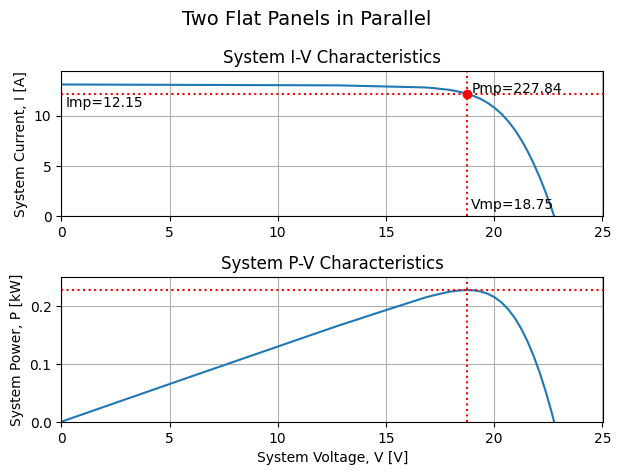

In [46]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=2, pvmods=[pvm])
sun = getSun(surface_tilt=0, shaded=False)
pvs.setSuns(sun)
pvs.setTemps(panel_temp)
plot_system(pvs, title='Two Flat Panels in Parallel')
pmp_baseline = pvs.Pmp

#### Case 0.1 - Two flat 12V panels in series

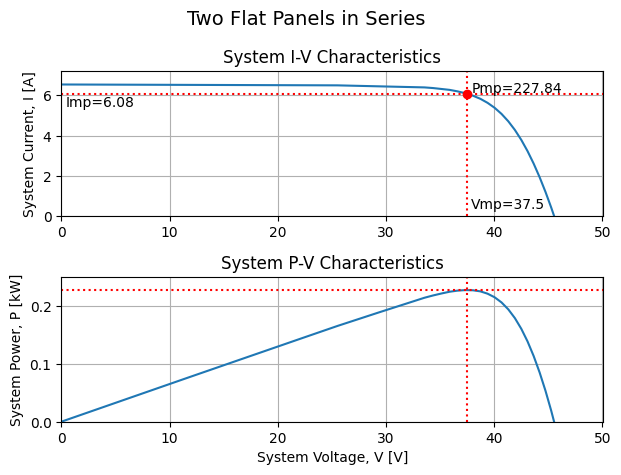

In [47]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm, pvm])
sun = getSun(surface_tilt=0, shaded=False)
pvs.setSuns(sun)
pvs.setTemps(panel_temp)
plot_system(pvs, title='Two Flat Panels in Series')

### Case 1 - Curved or Angled Roof Mount: Two panels angled slightly opposite of each other

Summary: The parallel configuration results in a negligable reduction in output compared to a 4.38% loss for the series configuration.

#### Case 1.0 - Two opposite angled (5 degrees) panels in parallel

Reduction in output:  0.32 %


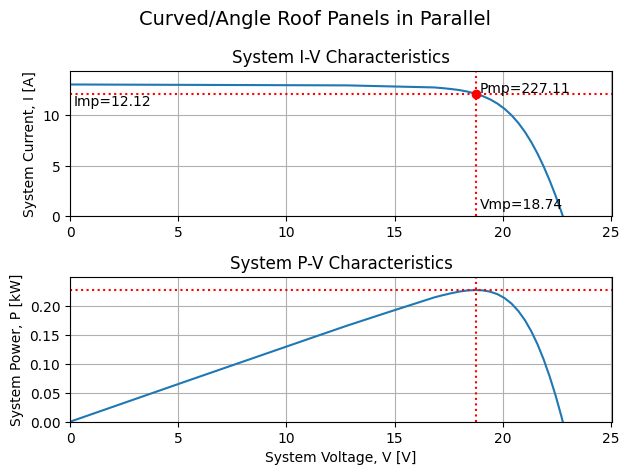

In [48]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=2, pvmods=[pvm])
sun_plus_5 = getSun(surface_tilt=-5, shaded=False)
sun_minus_5 = getSun(surface_tilt=5, shaded=False)
pvs.setSuns({0: {0: sun_minus_5}, 1: {0: sun_plus_5}})
pvs.setTemps(panel_temp)
plot_system(pvs, title='Curved/Angle Roof Panels in Parallel')
derate10 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate10)*100,2), '%')

#### Case 1.1 - Two opposite angled (5 degree) panels in series

Reduction in output:  4.27 %


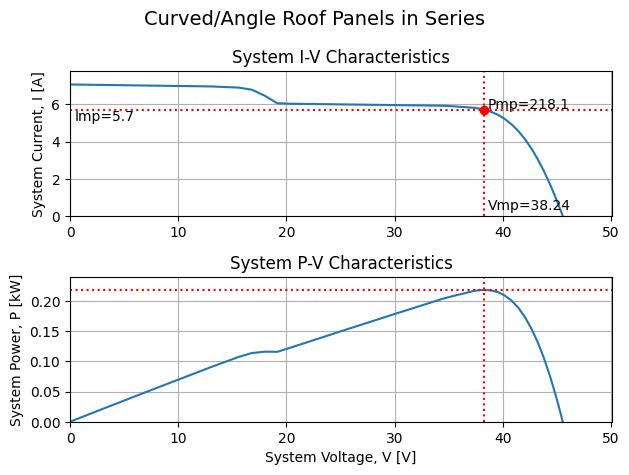

In [49]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm, pvm])
sun_plus_5 = getSun(surface_tilt=-5, shaded=False)
sun_minus_5 = getSun(surface_tilt=5, shaded=False)
pvs.setSuns({0: {0: sun_minus_5, 1: sun_plus_5}})
pvs.setTemps(panel_temp)
plot_system(pvs, title='Curved/Angle Roof Panels in Series')
derate11 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate11)*100,2), '%')

### Case 2 - Roof Mount plus Ground Array: One flat panel + One 45 degree panel

Summary: The parallel case sees an increase of 20% power production, while the series configuration only sees and increase of 6% power productionl.  This situation clearly favors the parallel configuration.  Of note is the negligable benefit of a separate MPPT controller (0.01% better than parallel with a common MPPT).  This suggests that as long as the same panels are in use, such that Vmpp is the essentially the same, a separate MPPT is not justified even under different exposure conditions.

#### Case 2.0 - One flat panel and one 45 degree tilted panel in parallel

Increase in output:  20.58 %


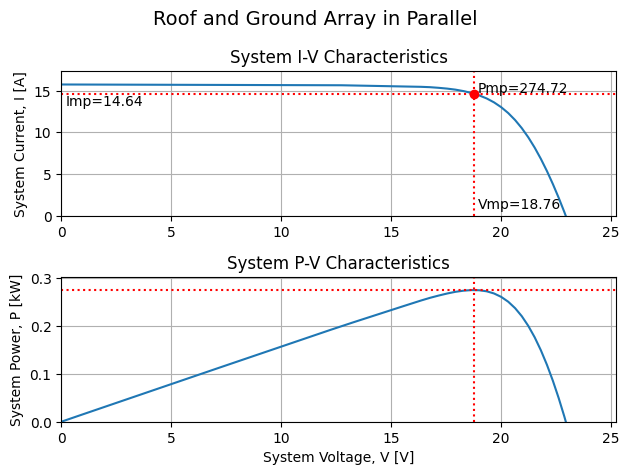

In [50]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=2, pvmods=[pvm])
sun_plus_45 = getSun(surface_tilt=45, shaded=False)
sun_flat = getSun(surface_tilt=0, shaded=False)
pvs.setSuns({0: {0: sun_plus_45}, 1: {0: sun_flat}})
pvs.setTemps(panel_temp)
plot_system(pvs, title='Roof and Ground Array in Parallel')
derate20 = pvs.Pmp / pmp_baseline
print('Increase in output: ', -1*round((1-derate20)*100,2), '%')

#### Case 2.1 - One flat panel and one 45 degree tilted panel in series

Increase in output:  6.81 %


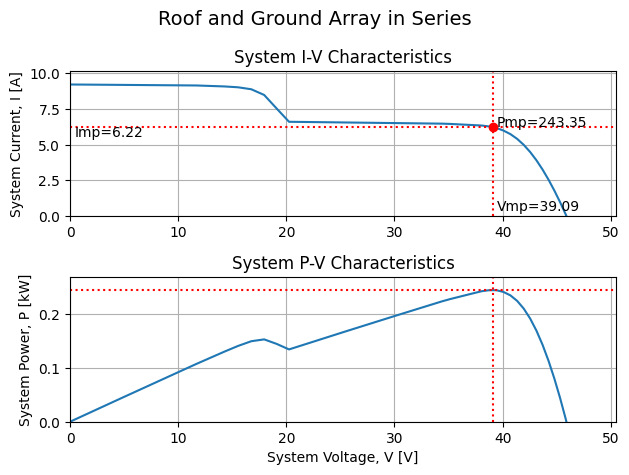

In [51]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm, pvm])
sun_plus_45 = getSun(surface_tilt=45, shaded=False)
sun_flat = getSun(surface_tilt=0, shaded=False)
pvs.setSuns({0: {0: sun_plus_45, 1: sun_flat}})
pvs.setTemps(panel_temp)
plot_system(pvs, title='Roof and Ground Array in Series')
derate21 = pvs.Pmp / pmp_baseline
print('Increase in output: ', -1*round((1-derate21)*100,2), '%')

#### Case 2.2 One flat panel, one 45 degree tilted panel, separate MPPT controllers

Increase in output:  20.57 %


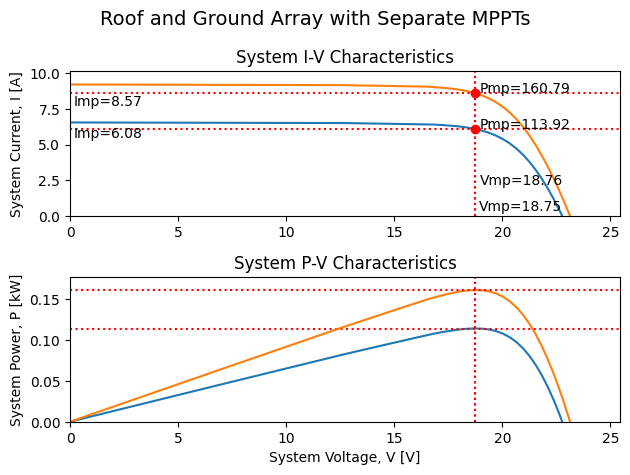

In [52]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_plus_45 = getSun(surface_tilt=45, shaded=False)
pvs.setSuns(sun_flat)
pvs.setTemps(panel_temp)
plot_system(pvs)
flat_power = pvs.Pmp
pvs.setSuns(sun_plus_45)
pvs.setTemps(panel_temp)
plot_system(pvs, title='Roof and Ground Array with Separate MPPTs')
tilted_power = pvs.Pmp
derate22 = (flat_power + tilted_power) / pmp_baseline
print('Increase in output: ', -1*round((1-derate22)*100,2), '%')

### Case 3 Basic Roof Mount with Shading: Two Flat mounted panels with one shaded

Summary: The parallel case sees a 42% reduction in power, while the series configuration sees a 53% reduction in power.  While both are significantly affected by shading, the parallel case is more resilliant.

#### Case 3.0 Two flat 12V panels, with one shaded, in parallel

Reduction in output:  42.11 %


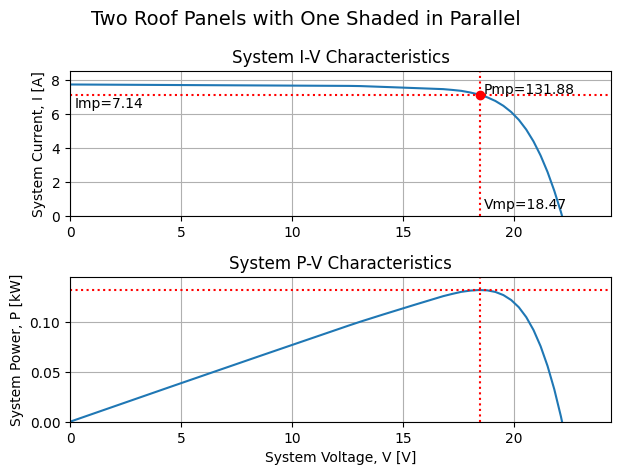

In [53]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=2, pvmods=[pvm])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_flat_shaded = getSun(surface_tilt=0, shaded=True)
pvs.setSuns({0: {0: sun_flat}, 1: {0: sun_flat_shaded}})
pvs.setTemps(panel_temp)
plot_system(pvs, title='Two Roof Panels with One Shaded in Parallel')
derate30 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate30)*100,2), '%')

#### Case 3.1 Two flat 12V panels, with one shaded, in series

Reduction in output:  53.11 %


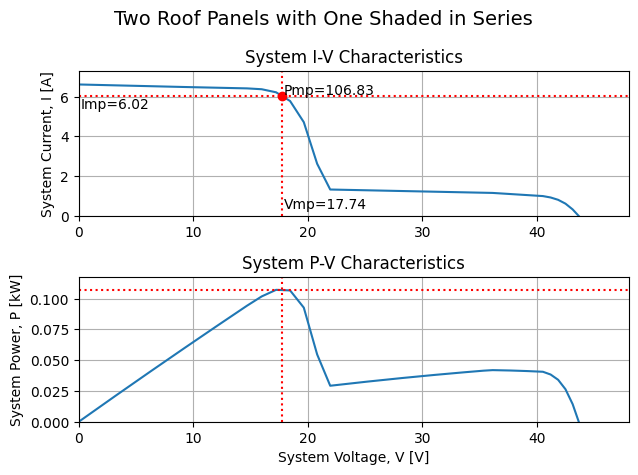

In [54]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm, pvm])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_flat_shaded = getSun(surface_tilt=0, shaded=True)
pvs.setSuns({0: {0: sun_flat, 1: sun_flat_shaded}})
pvs.setTemps(panel_temp)
plot_system(pvs, title='Two Roof Panels with One Shaded in Series')
derate31 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate31)*100,2), '%')

### Case 4 - Four Panel Roof Mount with One Panel Shaded

Summary: As in all other cases, the parallel configuration experiences less reduction in power (21%), compared to the 2S4P configuration (40.77%), and 4S configuration (26.5%).  Of arguable more interest, is that the reduction in power in the 2S4P case exceeds the percentage of shaded panels (25%) and exceeds the reduction in power of the all series case.  This strongly suggests parallel configurations are optimal for RV and marine applications when possible.  It also suggests that all series arrangements are superior to mixed configuration as it maximizes the effect of the bypass diodes at minmizing power reduction.

#### Case 4.0 - Four flat 12V panels in parallel (4P), one shaded

Reduction in output:  21.04 %


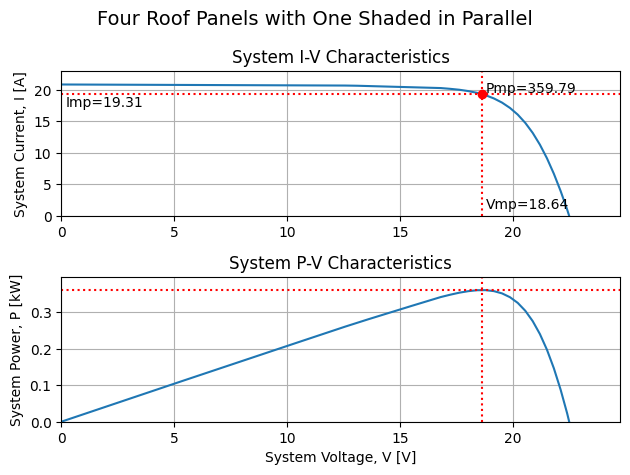

In [55]:
#Establish new baseline
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=4, pvmods=[pvm])
sun_flat = getSun(surface_tilt=0, shaded=False)
pvs.setSuns(sun_flat)
pvs.setTemps(panel_temp)
pmp_baseline = pvs.Pmp

#Proceed with case 4.0
sun_flat_shaded = getSun(surface_tilt=0, shaded=True)
pvs.setSuns({0: {0: sun_flat}, 1: {0: sun_flat}, 2: {0: sun_flat}, 3: {0: sun_flat_shaded}})
pvs.setTemps(panel_temp)
plot_system(pvs, title='Four Roof Panels with One Shaded in Parallel')
derate40 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate40)*100,2), '%')

#### Case 4.1 - Four flat 12V panels in 2S2P, one shaded

Reduction in output:  40.83 %


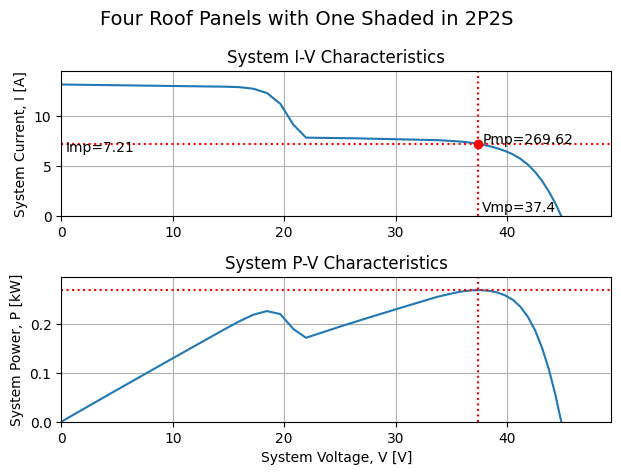

In [56]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=2, pvmods=[pvm, pvm])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_flat_shaded = getSun(surface_tilt=0, shaded=True)
pvs.setSuns({0: {0: sun_flat, 1: sun_flat_shaded}, 1: {0: sun_flat, 1: sun_flat}})
pvs.setTemps(panel_temp)
plot_system(pvs, title='Four Roof Panels with One Shaded in 2P2S')
derate41 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate41)*100,2), '%')

#### Case 4.2 - Four flat 12V panels in 4S, one shaded

Reduction in output:  26.5 %


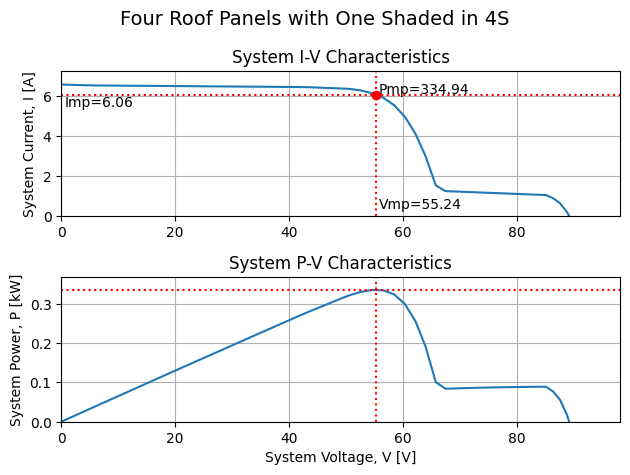

In [57]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm, pvm, pvm, pvm])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_flat_shaded = getSun(surface_tilt=0, shaded=True)
pvs.setSuns({0: {0: sun_flat, 1: sun_flat, 2: sun_flat, 3: sun_flat_shaded}})
pvs.setTemps(panel_temp)
plot_system(pvs, title='Four Roof Panels with One Shaded in 4S')
derate42 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate42)*100,2), '%')

### Case 5 - Two Different Makes of Panels
Summary:  Parallel wins again over series (1.6% loss vs 5.4%).  Of note is the minimal difference between parallel and using separate MPPTs for each panel type.  However, this difference will depend strongly on how different the panels are.  Generally one not mix panel types on a single MPPT.

Note: We use temperature and irradiance to simulate different makes of solar panels because PVMismatch doesn't support different models of PV modules in series.

#### Case 5.0 Two different makes of panels, separate MPPTs

Baseline output:  216.53 W


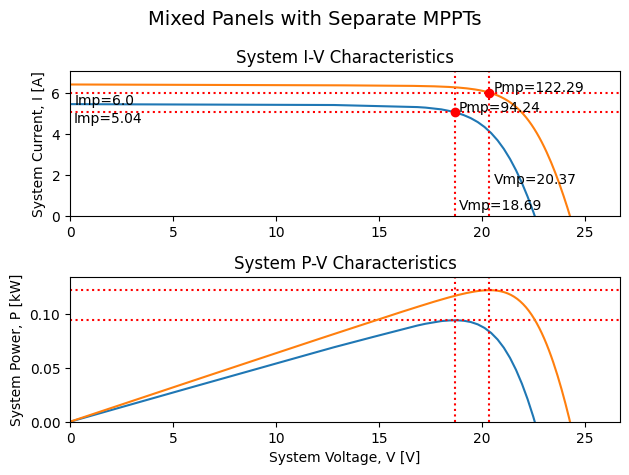

In [58]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_minus_10 = getSun(surface_tilt=-10, shaded=False)
pvs.setSuns(sun_minus_10)
pvs.setTemps(298.15+25)
plot_system(pvs)
tilted_power = pvs.Pmp
pvs.setSuns(sun_flat)
pvs.setTemps(298.15)
plot_system(pvs, title='Mixed Panels with Separate MPPTs')
flat_power = pvs.Pmp
pmp_baseline = flat_power + tilted_power
print('Baseline output: ', round(pmp_baseline,2), 'W')

#### Case 5.1 Two different makes of panels, in parallel 

Reduction in output:  1.6 %


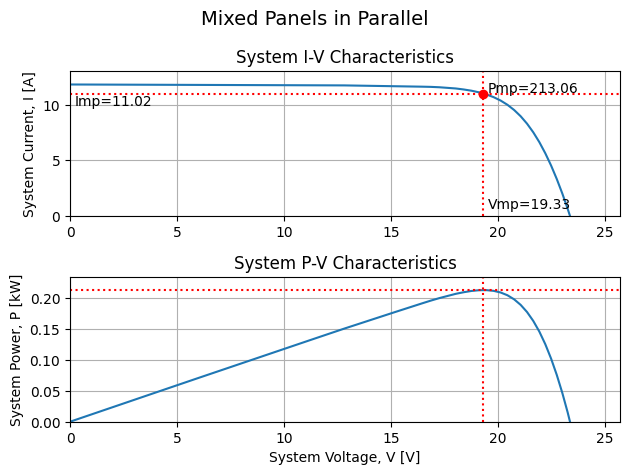

In [59]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=2, pvmods=[pvm])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_minus_10 = getSun(surface_tilt=-10, shaded=False)
pvs.setSuns({0: sun_minus_10, 1: sun_flat})
pvs.setTemps({0: 298.15+25, 1: 298.15})
plot_system(pvs, title='Mixed Panels in Parallel')
derate51 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate51)*100,2), '%')

#### Case 5.2 Two different makes of panels, in series

Reduction in output:  4.89 %


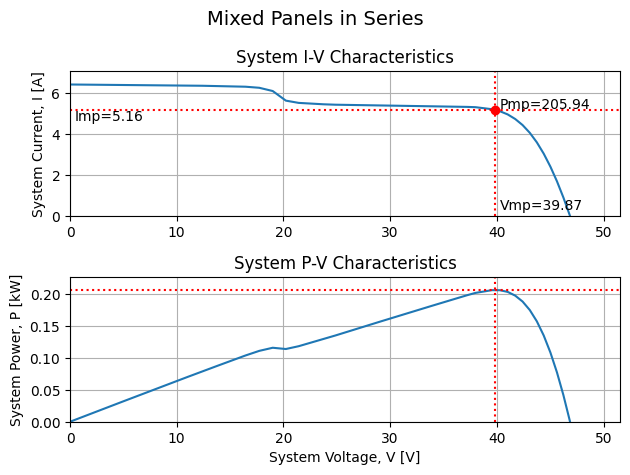

In [60]:
pvs = pvmismatch.pvsystem.PVsystem(numberStrs=1, pvmods=[pvm, pvm])
sun_flat = getSun(surface_tilt=0, shaded=False)
sun_minus_10 = getSun(surface_tilt=-10, shaded=False)
pvs.setSuns({0: {0: sun_minus_10, 1: sun_flat}})
pvs.setTemps({0: {0: 298.15+25, 1: 298.15}})
plot_system(pvs, title='Mixed Panels in Series')
derate52 = pvs.Pmp / pmp_baseline
print('Reduction in output: ', round((1-derate52)*100,2), '%')